In [1]:
# Import libraries
import moments, moments.LD
import pandas as pd, numpy as np
from collections import defaultdict
import demes, demesdraw, matplotlib.pylab as plt
import msprime as ms

import model as m, slice, get_LD, plot_LD

##### Functions

In [2]:
def plot_iicr(iirc,T): 
    plt.plot(T, iirc)
    plt.xticks(fontsize= 12)
    plt.yticks(fontsize= 12)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("time ago (years)",fontsize = 14)
    plt.ylabel(r"IICR",fontsize = 14);

In [3]:
def plot_comparison(LDpop1,LDpop2,labels=["Original","Size Change"]):
    rhos = np.logspace(-2, 2, 21)
    
    # plot D2
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    ax.plot(rhos,LDpop1[:,0],label=labels[0])
    ax.plot(rhos,LDpop2[:,0],label=labels[1])
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"$\sigma_d^2$")
    ax.set_xlabel(r"$\rho$")

    # plot DZ
    ax2.plot(rhos,LDpop1[:,1],label=labels[0])
    ax2.plot(rhos,LDpop2[:,1],label=labels[1])
    ax2.legend()
    ax2.set_yscale("log")
    ax2.set_xscale("log")
    ax2.set_ylabel(r"$\sigma_{Dz}$")
    ax2.set_xlabel(r"$\rho$")

    plt.tight_layout()
    plt.show()

In [4]:
def get_N_times_from_iicr(iicr,T):
    """
    Takes an the inverse inferred rate of coalescence and the time points and returns the times at which size changes.
    """
    previous_N = np.flip(iicr)[0]
    Ns = []
    times = []
    for N,time in zip(np.flip(iicr),np.flip(T)):
        if int(N) != previous_N:
            print(N,time)
            Ns.append(previous_N)
            times.append(time)
            previous_N = int(N)

    Ns.append(N)        
    times.append(0)
    print(Ns)
    print(times)
    return Ns,times

def size_change_from_iicr(iicr,T,yaml_filename=None,plot=True,plot_filename=None,time_units="years",generation_time=29):
    """
    Takes a vector of Ns in form of iicr and T times to create a model
    """
    if time_units == "generations":
        generation_time=1

    Ns,times = get_N_times_from_iicr(iicr,T)
    
    print("size change from IICR")
    print(Ns,times)
    
    m = demes.Builder(time_units=time_units,generation_time=generation_time)

    #current_time=np.array(time_period).sum()

    epochs = []
    for N,time in zip(Ns,times):
        epoch = dict(start_size=N,end_time=time)
        epochs.append(epoch)

    print(epochs)
    m.add_deme("Deme",epochs=epochs)
    print("added epochs")
    
    # Resolve model
    graph = m.resolve()
    print("resolved")
    # option to save to yaml
    if yaml_filename != None:
        demes.dump(graph, yaml_filename, format='yaml', simplified=True)
    
    if plot:
        p = demesdraw.tubes(graph, log_time=True, num_lines_per_migration=3)
        if plot_filename != None:
            p.figure.savefig(plot_filename+".pdf")
    
    return graph  
    

In [5]:
def run_LD_analysis_from_model(model,time_units="generations",generation_time=1):
    # Sample times at epochs
    T,_ = slice.sample_timepoints(model,anc_end_time=1e6/29)
    # Compute LD 
    model_sliced = slice.slice_timepoints(model,time_points=[0])
    model_sliced_LD = get_LD.get_LD_from_sliced_demes(model_sliced)
    # Get IIRC
    if time_units == "years":
        time_iicr=T/29
    else:
        time_iicr=T
    _, model_iicr, _ = m.get_iicr(model,pop="Merge_1",T=time_iicr)
    plot_iicr(model_iicr,T)

    print(T)
    print(model_iicr)
    
    model_sc = size_change_from_iicr(model_iicr,T,time_units=time_units,generation_time=generation_time,plot=True)
    print("sizechange")
    # Slice the generated model and get LD
    model_sc_sliced = slice.slice_timepoints(model_sc,time_points=[0])
    model_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(model_sc_sliced)
    # Get signal magnitude
    x = model_sliced_LD['Merge_1'][-1] # Model
    y = model_sc_sliced_LD['Deme'][-1] # size change
    plot_comparison(x,y)
    
    return 

In [6]:
def size_change(Ns,time_period,yaml_filename=None,plot=True,plot_filename=None,time_units="years",generation_time=29):
    
    if time_units == "generations":
        generation_time=1

    m = demes.Builder(time_units=time_units,generation_time=generation_time)
    current_time=np.array(time_period).sum()

    epochs = []
    for N,time in zip(Ns,time_period):
        epoch = dict(start_size=N,end_time=current_time-time)
        current_time=current_time-time
        epochs.append(epoch)

    m.add_deme("Deme",epochs=epochs)

    # Resolve model
    graph = m.resolve()

    # Check demographic events
    print(epochs)
    
    # option to save to yaml
    if yaml_filename != None:
        demes.dump(graph, yaml_filename, format='yaml', simplified=True)
    
    if plot:
        p = demesdraw.tubes(graph, log_time=True, num_lines_per_migration=3)
        if plot_filename != None:
            p.figure.savefig(plot_filename+".pdf")
    
    return graph 

##### Arguments for models

In [7]:
N = 20e3
time_period = 0.1*N

##### 1. Constant population

<AxesSubplot:ylabel='time ago (generations)'>

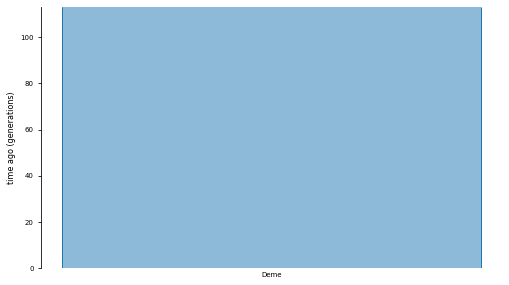

In [14]:
constant = demes.Builder()
constant.add_deme("Deme",epochs=[dict(start_size=N)])
graph = constant.resolve()
demesdraw.tubes(graph, log_time=False, num_lines_per_migration=3)

In [15]:
T,times_dic = slice.sample_timepoints(graph)

In [16]:
# Compute LD 
c_sliced = slice.slice_timepoints(graph,time_points=[0])
c_sliced_LD = get_LD.get_LD_from_sliced_demes(c_sliced)

In [17]:
c_R, c_iicr, _ = model.get_iicr(graph,pop="Deme",T=T)
c_sc = model.size_change_from_iicr(c_iicr,T,time_units="generations",plot=False)

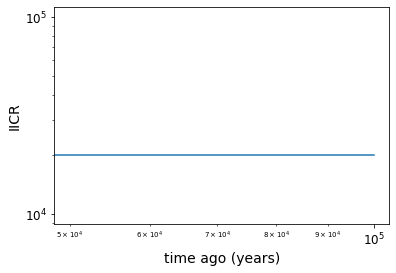

In [18]:
plot_iicr(c_iicr,T)

In [19]:
# Actually slice
c_sc_sliced = slice.slice_timepoints(c_sc,time_points=[0])
c_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(c_sc_sliced)

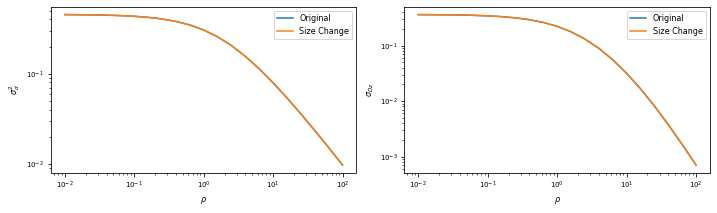

In [20]:
plot_comparison(c_sliced_LD['Deme'][-1],c_sc_sliced_LD['Deme'][-1])

##### 2. Size change - No structure

[{'start_size': 20000.0, 'end_time': 4000.0}, {'start_size': 2000.0, 'end_time': 1000.0}, {'start_size': 10000.0, 'end_time': 0.0}]


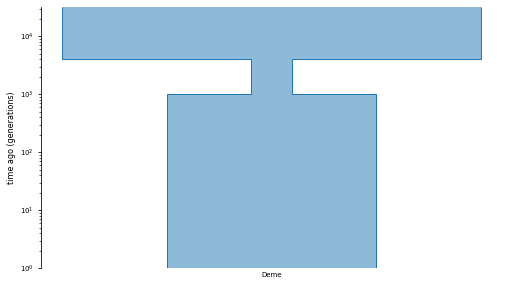

In [8]:
sc_model = size_change(Ns=[N,N/10,N/2],time_period=[time_period,time_period*1.5,time_period/2],time_units="generations")

In [9]:
# Sample times at epochs
T,times_dic = slice.sample_timepoints(sc_model)
# Compute LD 
sc_sliced = slice.slice_timepoints(sc_model,time_points=[0])
sc_sliced_LD = get_LD.get_LD_from_sliced_demes(sc_sliced)

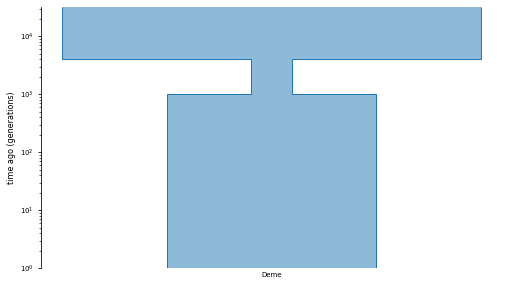

In [13]:
# Get IIRC
sc_R, sc_iicr, _ = m.get_iicr(sc_model,pop="Deme",T=T)
sc_sc = m.size_change_from_iicr(sc_iicr,T,time_units="generations",plot=True)

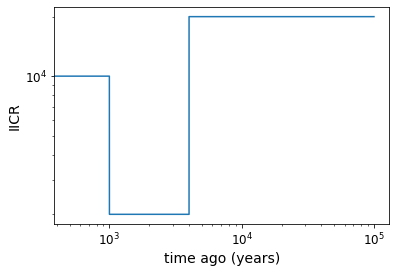

In [24]:
plot_iicr(sc_iicr,T)

In [25]:
# Slice the generated model and get LD
sc_sc_sliced = slice.slice_timepoints(sc_sc,time_points=[0])
sc_sc_sliced_LD = get_LD.get_LD_from_sliced_demes(sc_sc_sliced)

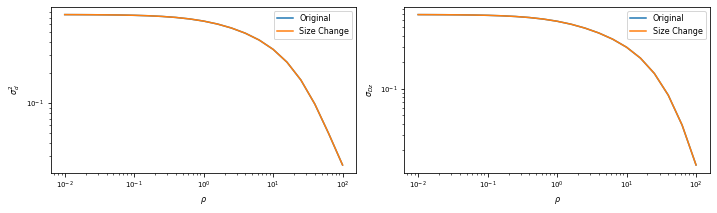

In [26]:
plot_comparison(sc_sliced_LD['Deme'][-1],sc_sc_sliced_LD['Deme'][-1])

##### 3. Bubble, inspired from Mende

[Split(parent='Ancestral', children=['Split_01', 'Split_00'], time=3448.0)]


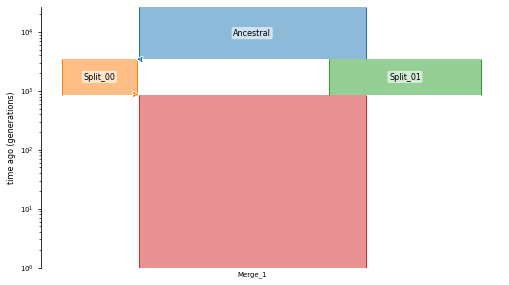

In [11]:
alpha1=[0.33,0.67]
alpha2=[0.819,0.181]
N=11.5e3

generation_time=29
time_period_merge_yrs =[1e6,25e3]
time_period_merge_gen = np.round(np.array(time_period_merge_yrs)/generation_time)
time_period_splits_yrs=[75e3]
time_period_splits_gen=np.round(np.array(time_period_splits_yrs)/generation_time)

bubble = m.cake_model(Ns=[N,N],splits=[2],alpha1=[alpha1],alpha2=[alpha2],time_period_merge=time_period_merge_gen,time_period_splits=time_period_splits_gen,migration_rate=0,time_units="generations",generation_time=1,plot=True)


[    0.           431.           861.           862.
  2155.          3447.          3448.         18965.37931034
 34481.75862069]
[11500.         11500.         11500.          5524.84567197
  5833.03541015  6196.16891106 11500.         11500.
 11500.        ]
11500.000000000005 34481.75862068965
6196.168911056859 3447.0
5833.035410147598 2155.0
5524.845671970641 862.0
11500.0 861.0
[11500.000000000005, 11500, 6196, 5833, 5524, 11500.0]
[34481.75862068965, 3447.0, 2155.0, 862.0, 861.0, 0]
size change from IICR
[11500.000000000005, 11500, 6196, 5833, 5524, 11500.0] [34481.75862068965, 3447.0, 2155.0, 862.0, 861.0, 0]
[{'start_size': 11500.000000000005, 'end_time': 34481.75862068965}, {'start_size': 11500, 'end_time': 3447.0}, {'start_size': 6196, 'end_time': 2155.0}, {'start_size': 5833, 'end_time': 862.0}, {'start_size': 5524, 'end_time': 861.0}, {'start_size': 11500.0, 'end_time': 0}]
added epochs
resolved
sizechange


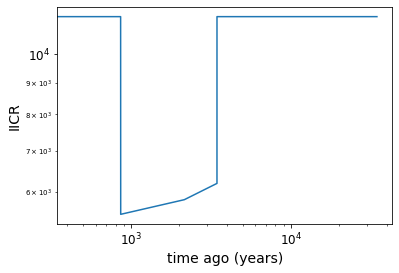

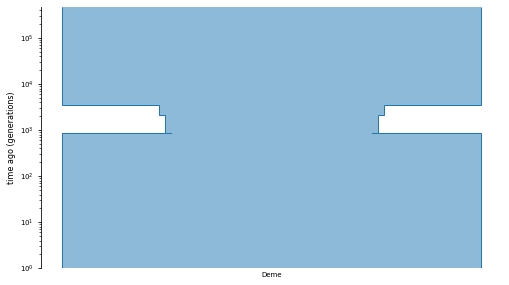

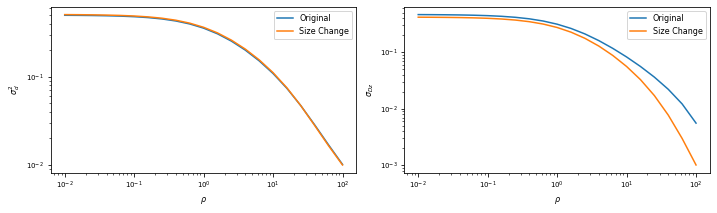

In [12]:
run_LD_analysis_from_model(bubble)

4. Bubble, symmetric alpha, no migration

[Split(parent='Ancestral', children=['Split_01', 'Split_00'], time=3448.0)]


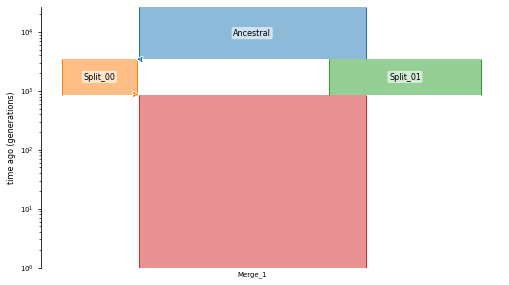

In [51]:
alpha1=[0.33,0.67]
alpha2=[0.33,0.67]
N=11.5e3

generation_time=29
time_period_merge_yrs =[1e6,25e3]
time_period_merge_gen = np.round(np.array(time_period_merge_yrs)/generation_time)
time_period_splits_yrs=[75e3]
time_period_splits_gen=np.round(np.array(time_period_splits_yrs)/generation_time)

bubble = m.cake_model(Ns=[N,N],splits=[2],alpha1=[alpha1],alpha2=[alpha2],time_period_merge=time_period_merge_gen,time_period_splits=time_period_splits_gen,migration_rate=0,time_units="generations",generation_time=1,plot=True,yaml_filename="Bubble_symmetric_alpha-Mende.yaml")


[    0.           431.           861.           862.
  2155.          3447.          3448.         18965.37931034
 34481.75862069]
[11500.         11500.         11500.         11500.
 12174.101824   12905.98557244 11500.         11500.
 11500.        ]
11500.0 34481.75862068965
11499.999999999996 3447.0
12174.101823999497 2155.0
12905.985572439919 862.0
11499.999999999996 861.0
[11499.999999999985, 11500, 11499, 12174, 12905, 11499.999999999985]
[34481.75862068965, 3447.0, 2155.0, 862.0, 861.0, 0]
size change from IICR
[11499.999999999985, 11500, 11499, 12174, 12905, 11499.999999999985] [34481.75862068965, 3447.0, 2155.0, 862.0, 861.0, 0]
[{'start_size': 11499.999999999985, 'end_time': 34481.75862068965}, {'start_size': 11500, 'end_time': 3447.0}, {'start_size': 11499, 'end_time': 2155.0}, {'start_size': 12174, 'end_time': 862.0}, {'start_size': 12905, 'end_time': 861.0}, {'start_size': 11499.999999999985, 'end_time': 0}]
added epochs
resolved
sizechange


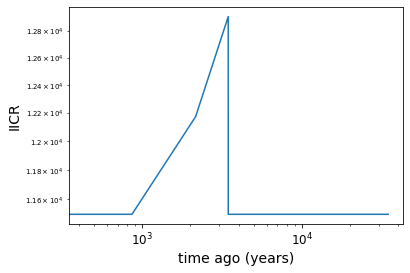

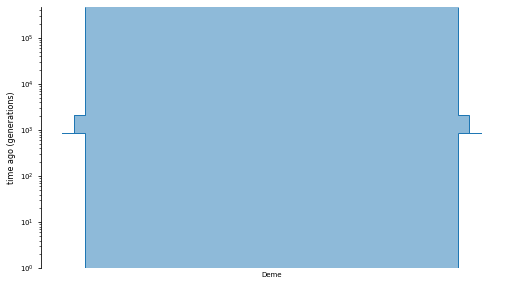

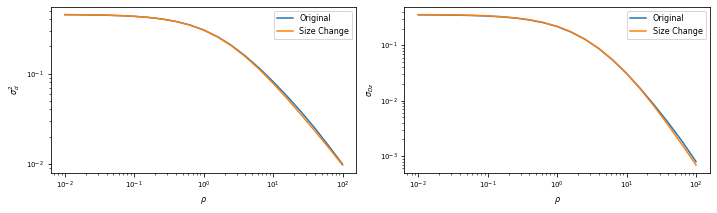

In [113]:
run_LD_analysis_from_model(bubble)

##### 5. Isolation with Migration model

<AxesSubplot:ylabel='time ago (generations)'>

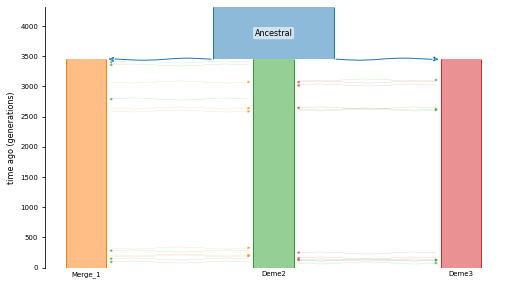

In [55]:
migration_rate1=1e-4
migration_rate2=1e-2

m = demes.Builder(time_units="generations")

#  Add first Ancestor
m.add_deme("Ancestral",epochs=[dict(start_size=N, end_time=N*0.3)])

m.add_deme("Merge_1",ancestors=["Ancestral"],epochs=[dict(start_size=N/3)])
m.add_deme("Deme2",ancestors=["Ancestral"],epochs=[dict(start_size=N/3)])
m.add_deme("Deme3",ancestors=["Ancestral"],epochs=[dict(start_size=N/3)])
m.add_migration(demes = ["Merge_1","Deme2"], rate = migration_rate1, end_time=2500)
m.add_migration(demes = ["Deme3","Deme2"], rate = migration_rate1, end_time=2500)

m.add_migration(demes = ["Merge_1","Deme2"], rate = migration_rate1, start_time=time_period/6, end_time=1)
m.add_migration(demes = ["Deme3","Deme2"], rate = migration_rate2, start_time=time_period/6 ,end_time=1)

IM = m.resolve()
demesdraw.tubes(IM, log_time=False, num_lines_per_migration=3)

[    0.          1725.          3449.          3450.
 18966.37931034 34481.75862069]
[ 3833.33333333  4149.82843799  5019.6943848  11500.
 11500.         11500.        ]
3833.3333333333335 34481.75862068965
4149.828437990263 18966.379310344826
5019.694384800486 3450.0
11500.0 3449.0
[11500.0, 3833, 4149, 5019, 11500.0]
[34481.75862068965, 18966.379310344826, 3450.0, 3449.0, 0]
size change from IICR
[11500.0, 3833, 4149, 5019, 11500.0] [34481.75862068965, 18966.379310344826, 3450.0, 3449.0, 0]
[{'start_size': 11500.0, 'end_time': 34481.75862068965}, {'start_size': 3833, 'end_time': 18966.379310344826}, {'start_size': 4149, 'end_time': 3450.0}, {'start_size': 5019, 'end_time': 3449.0}, {'start_size': 11500.0, 'end_time': 0}]
added epochs
resolved
sizechange


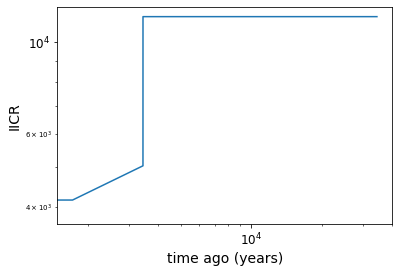

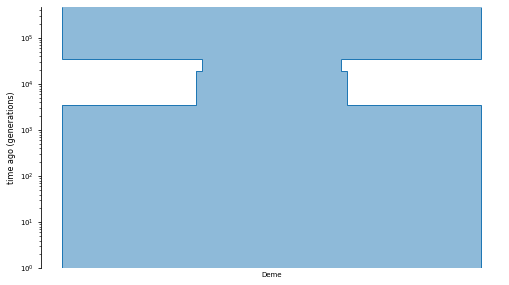

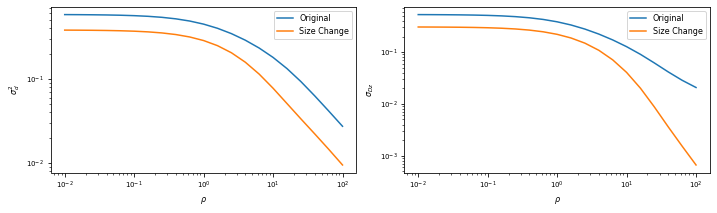

In [112]:
run_LD_analysis_from_model(IM)

In [ ]:
IM = model.cake_model(Ns=[N,N/3],splits=[3],proportions=[[1/3,1/3,1/3]],time_period_merge=[N,0],time_period_splits=[N],migration_rate=0.02,generation_time=1)

In [ ]:
# Sample times at epochs
T,times_dic = slice.sample_timepoints(IM)
# Compute LD 
im_sliced = slice.slice_timepoints(IM,time_points=[0])
im_sliced_LD = get_LD.get_LD_from_sliced_demes(im_sliced)

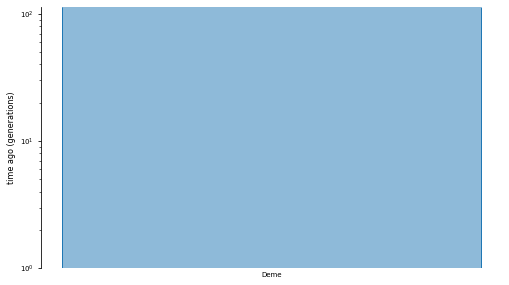

In [ ]:
# Get IIRC
im_R,im_iicr, _ = model.get_iicr(IM,pop="Deme1",T=T)
im_sc = model.size_change_from_iicr(im_iicr,times_dic['Deme1'],time_units="generations",plot=True)